In [1]:
from datetime import datetime
from functools import reduce
from functools import partial
import operator
import os
from timeit import default_timer

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

/Users/skp340/opt/anaconda3/envs/ndmd-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import einops
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

In [4]:
%matplotlib inline

torch.manual_seed(0)
np.random.seed(0)

print(torch.cuda.is_available())

False


### Utilities

In [5]:
class LpLoss(object):
    """Computes relative and absolute L^{p} loss functions."""

    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        assert d > 0 and p > 0

        self.dim = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        """Computes absolute error, assuming a uniform mesh."""

        batch_size = x.shape[0]

        h = 1.0 / (x.shape[1] - 1.0)

        all_norms = (h**(self.dim/self.p))*torch.norm(
                            x.view(batch_size,-1) - y.view(batch_size,-1),
                            self.p,
                            1,) # axis

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        """Computes relative error."""

        num_examples = x.size()[0]

        diff_norms = torch.norm(
                        x.reshape(num_examples,-1) - y.reshape(num_examples,-1),
                        self.p,
                        1,) # axis
        y_norms = torch.norm(y.reshape(num_examples,-1),
                            self.p,
                            1,)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [6]:
class UnitGaussianNormalizer(object):
    """Applies pointwise Gaussian normalization to an input tensor."""
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()
        """Args:
            x: tensor of shape (ntrain X n) or (ntrain X T X n) or
                (ntrain X n X T)
        """
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # (batch X n)
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # (T X batch X n)
                mean = self.mean[:,sample_idx]

        # x in shape of (batch X n) or (T X batch X n)
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

    def to(self, device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)

In [7]:
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

In [8]:
def mat_to_tensor2d(TRAIN_PATH, 
                  TEST_PATH, 
                  ss_rate, 
                  x_field, y_field, 
                  vsamples=None, 
                  normalize=False):
    """Converts .mat file contents to torch tensors.

        Args:
            TRAIN_PATH: list of .mat file names to concatenate into training 
                        tensors
            TEST_PATH: list of .mat file names to concatenate into test tensors
            ss_rate: [train subsampling rate, test rate]
            x_field, y_field: names of fields in the .mat file
            vsamples: [ntest, ntrain]
            print: Print log contents to the console; default = True
            normalize: Apply normalization to the tensors; default = False
    """
    t1 = default_timer()

    reader = MatReader(TRAIN_PATH)
    x_data = reader.read_field(x_field)
    y_data = reader.read_field(y_field)
    dimension = len(x_data.shape) - 1
    
    mat_info = {
        "input signal vector samples": x_data.shape[0],
        "output signal vector samples": y_data.shape[0],
        "input signal entry samples": x_data.shape[1],
        "output signal entry samples": y_data.shape[1],
        "signal dimension": dimension
    }
    print(mat_info)

    ntrain = vsamples[0]
    ntest = vsamples[1]

    full_res = x_data.shape[1]
    tr_ss = ss_rate[0]
    tst_ss = ss_rate[1]
    tr_esamples = int(((full_res - 1)/tr_ss) + 1)

    x_train = x_data[:ntrain,::tr_ss,::tr_ss][:,:tr_esamples,:tr_esamples]
    y_train = y_data[:ntrain,::tr_ss,::tr_ss][:,:tr_esamples,:tr_esamples]

    if TRAIN_PATH != TEST_PATH:
        # using separate files for test/train data
        test_reader = MatReader(TEST_PATH)
        x_test = test_reader.read_field(x_field)
        y_test = test_reader.read_field(y_field)

        full_res = x_test.shape[1]
        tst_esamples = int(((full_res - 1)/tst_ss) + 1)

        x_test = x_test[:ntest,::tst_ss,::tst_ss][:,:tst_esamples,:tst_esamples]
        y_test = y_test[:ntest,::tst_ss,::tst_ss][:,:tst_esamples,:tst_esamples]

    else:
        full_res = x_data.shape[1]
        tst_esamples = int(((full_res - 1)/tst_ss) + 1)

        # same file; use last (ntest) samples
        x_test = x_data[-ntest:,::tst_ss,::tst_ss][:,:tst_esamples,:tst_esamples]
        y_test = y_data[-ntest:,::tst_ss,::tst_ss][:,:tst_esamples,:tst_esamples]

        
    ds_info = {
        "training dataset": TRAIN_PATH,
        "test dataset": TEST_PATH,
        "input train samples": x_train.shape[0],
        "output train samples": y_train.shape[0],
        "input train resolution": x_train.shape[1],
        "output train resolution": y_train.shape[1],
        "input test samples": x_test.shape[0],
        "output test samples": y_test.shape[0],
        "input test resolution": x_test.shape[1],
        "output test resolution": y_test.shape[1]
    }
    print(ds_info)

    t2 = default_timer()
    
    return x_train, y_train, x_test, y_test, mat_info, ds_info

## Kernel

In [9]:
def complex_mul2d(a, b):
    """Performs complex multiplication between two input tensors.

    Args:
    a: tensor of shape (batch, in_channel, x, y)
    b: tensor of shape (in_channel, out_channel, x, y)

    return: tensor of form (batch, out_channel, x, y)
    """
    return torch.einsum("bixy,ioxy->boxy", a, b)

In [10]:
class SpectralConv2d(nn.Module):
    """Applies FFT, linear transform, and inverse FFT.
        
        Args:
            in_channels: number of input channels
            out_channels: number of output channels
            modes: list [x, y] of modes per dimension; number of Fourier 
                   modes to multiply (at most floor(N/2) + 1)
            train: Whether or not the weights are trainable parameters; 
                   default = True
    """
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 modes,
                 trainable=True):
        super(SpectralConv2d, self).__init__()
        

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.trainable = trainable
        self.scale = (1 / (in_channels * out_channels))

        
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, 
                                                            out_channels, 
                                                            self.modes[0], 
                                                            self.modes[1], 
                                                            2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, 
                                                            out_channels, 
                                                            self.modes[0], 
                                                            self.modes[1], 
                                                            2))
        self.weights1.requires_grad = trainable
        self.weights2.requires_grad = trainable

    def forward(self, x):
        batchsize = x.shape[0]
        
        # Compute Fourier coeffcients
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, 
                             self.out_channels,  
                             x.size(-2), 
                             x.size(-1)//2 + 1, 
                             dtype=torch.cfloat, 
                             device=x.device)
        
        out_ft[:, :, :self.modes[0], :self.modes[1]] = \
            compl_mul2d(x_ft[:, :, :self.modes[0], :self.modes[1]], 
                             self.weights1)
        out_ft[:, :, -self.modes[0]:, :self.modes[1]] = \
            compl_mul2d(x_ft[:, :, -self.modes[0]:, :self.modes[1]], 
                             self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, 
                             s=(x.size(-2), 
                                x.size(-1)))
        return x

In [11]:
class FourierBlock2d(nn.Module):
    """Fourier kernel block implementing
                    u' = (W + K)(u),
       where W is defined by a convolution and K is defined by 
       a spectral convolution in Fourier space.
    """
    def __init__(self,
                 width,
                 modes,
                 nonlinearity,
                 trainable=True):
        super(FourierBlock2d, self).__init__()
        """
        Args:
            modes: Number of Fourier modes to multiply (at most floor(N/2) + 1)
            width: Dimension of lifting transform performed by first layer
            nonlinearity: Component-wise nonlinear activation
            internal: True if block is not final output block
            train: Whether or not the weights are trainable parameters; 
                   default = True
        """
        
        self.width = width
        self.modes = modes
        self.trainable = trainable
        self.nonlinearity = nonlinearity
        
        # SpectralConv2d(in_dim, out_dim, modes_x, modes_y)
        self.R = SpectralConv2d(self.width, 
                                self.width, 
                                self.modes,
                                self.trainable)
        
        # ConvNd(in_dim, out_dim, kernel_size)
        self.w = nn.Conv1d(self.width, self.width, 1)
        self.w.weight.requires_grad = self.trainable
        self.w.bias.requires_grad = self.trainable
        
        
    def forward(self, x):
        dimx, dimy = x.shape[2], x.shape[3]
        
        Rx = self.R(x)

        Wx = einops.rearrange(x, 'b c x y -> b c (x y)')
        Wx = self.w(Wx)
        Wx = einops.rearrange(Wx, 'b c (x y) -> b c x y', x=dimx, y=dimy)
            
        if self.nonlinearity == None:
            return Rx + Wx
            
        else:
            # (x1 + x2) = 'b c x y'
            return self.nonlinearity(Rx + Wx)
            

In [12]:
class FourierKernel2d(nn.Module):
    """The Fourier kernel containing a specified number of Fourier blocks.
    
    1. Lift the input to the desired channel dimension by self.fc0.
    2. Apply specified number of iterations of the operator 
                            u' = (W + K)(u)
    3. Project from the channel space to the output space by self.fc1 
        and self.fc2.
    """
    def __init__(self, 
                 n_blocks, 
                 modes, 
                 width,
                 nonlinearity,
                 trainable=True):
        """
        Args:
            blocks: Number of kernel integral transform blocks
            modes: Number of Fourier modes to multiply (at most floor(N/2) + 1)
            width: Dimension of lifting transform performed by first layer
            nonlinearity: Component-wise nonlinear activation
        """
        super(FourierKernel2d, self).__init__()

        self.n_blocks = n_blocks
        self.modes = modes
        self.width = width
        self.nonlin = nonlinearity
        self.trainable = trainable

        # lift to dimension = self.width
        # input channel is 3: (a(x, y), x, y)
        self.fc0 = nn.Linear(3, self.width)
        
        self.blocks = nn.ModuleList()
        
        for b in range(self.n_blocks):
            
            if b == self.n_blocks - 1:
                self.blocks.append(FourierBlock2d(
                                        self.width,
                                        self.modes,
                                        None, 
                                        trainable=self.trainable))
            else:
                self.blocks.append(FourierBlock2d(
                                            self.width,
                                            self.modes,
                                            self.nonlin, 
                                            trainable=self.trainable))
        
        # return to input space
        self.fc1 = nn.Linear(self.width, self.width*self.n_blocks)
        self.fc2 = nn.Linear(self.width*self.n_blocks, 1)

        
    def forward(self, x):
        """Apply kernel transform to input data.
        Args:
            x: the solution of the coefficient function and locations 
                    (a(x, y), x, y); shape (batchsize, x=s, y=s, c=3)
            
            return: solution u(x, y); shape (batchsize, x=s, y=s, c=1)
        """        
        x = self.fc0(x)
        
        x = einops.rearrange(x, 'b x y c -> b c x y')

        for block in self.blocks:
            x = block(x)

        x = einops.rearrange(x, 'b c x y -> b x y c')
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
                
        return x

In [13]:
class OperatorNet(nn.Module):    
    def __init__(self, 
                 kernel, 
                 name=None):
        super(OperatorNet, self).__init__()
        
        self.kernel = kernel
        self.modelname = name
        
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))
        self.param_count = c
        
    def param_count(self):
        return self.param_count
    
    def name(self):
        return "model: {}".format(self.modelname)
    
    #def device(self):
     #   return self.device
        
    def forward(self, x):
        x = self.kernel(x)
        return x.squeeze()

# Training

In [ ]:
PATH = "../"

## Set up properties and I/O of training run

In [ ]:
train_ds_name = "piececonst_r241_N1024_smooth1"
test_ds_name = "piececonst_r241_N1024_smooth2"

TRAIN_PATH = PATH+train_ds_name+'.mat'
TEST_PATH = PATH+test_ds_name+'.mat'

# field name in the matlab file
x_name = "coeff"
y_name = "sol"

# dataset properties
ss_rate = [1, 1]
vsamples = [200, 200]

In [ ]:
# model properties
n_blocks = 3
modes = [16, 16]
width = 32
# training properties
trainable_blocks = True
learning_rate = 0.001
epochs = 250
step_size = 100
gamma = 0.5
batch_size = 20
nonlinearity = F.relu
# I/O properties
output_freq = 10
checkpoint_freq = 1000

now = datetime.now()
ts = now.strftime("%m%d%Y%H%M%S")

model_name = "{}_{}_{}_{}_{}_{}_{}".format(n_blocks, 
                                           train_ds_name, 
                                           ss_rate[0], 
                                           vsamples[0], 
                                           modes, 
                                           width, 
                                           ts)
model_path = PATH+"model/{}".format(model_name)
train_err_path = PATH+"results/{}_train.txt".format(model_name)
test_err_path = PATH+"results/{}_test.txt".format(model_name)
fig_path = PATH+"figures/{}_plot.png".format(model_name)

checkpt = PATH+"log/{}.pt".format(model_name)
path_log = PATH+"log/{}.txt".format(model_name)


run_properties = ("run properties:\n"
                "num. epochs: {}\n"
                "learning rate: {}\n"
                "step size: {}\n"
                "gamma: {}\n"
                "n_blocks: {}\n"
                "training dataset: {}\n"
                "subsampling rate: {}\n"
                "training samples: {}\n"
                "modes: {}\n"
                "width: {}\n\n").format(epochs, 
                                        learning_rate, 
                                        step_size, 
                                        gamma, 
                                        n_blocks, 
                                        train_ds_name, 
                                        ss_rate[0], 
                                        vsamples[0], 
                                        modes, 
                                        width,
                                        )
print(run_properties)

train_log = []
train_log.append(run_properties)

run properties:
num. epochs: 250
learning rate: 0.001
step size: 100
gamma: 0.5
n_blocks: 3
training dataset: piececonst_r241_N1024_smooth1
subsampling rate: 1
training samples: 200
modes: [16, 16]
width: 32




## Make tensors out of .mat

In [ ]:
x_train, y_train, x_test, y_test, mat_info, ds_info = mat_to_tensor2d(
                                                            TRAIN_PATH, 
                                                            TEST_PATH, 
                                                            ss_rate,
                                                            x_name, 
                                                            y_name,
                                                            vsamples=vsamples,
                                                            normalize=True,
                                                            )
print(mat_info)
print(ds_info)
train_log.append(mat_info)
train_log.append(ds_info)

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

input signal vector samples: 1024
output signal vector samples: 1024
input signal entry samples: 241
output signal entry samples: 241
signal dimension: 2


training dataset: /content/drive/MyDrive/Spring-2021/thesis/data/shared_data/piececonst_r241_N1024_smooth1.mat
test dataset: /content/drive/MyDrive/Spring-2021/thesis/data/shared_data/piececonst_r241_N1024_smooth2.mat

input train samples: 200
output train samples: 200
input train resolution: 241
output train resolution: 241

input test samples: 200
output test samples: 200
input test resolution: 241
output test resolution: 241




## Add spatial coordinate channel

In [ ]:
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
train_res = x_train.shape[1]
test_res = x_test.shape[1]

dimension = len(x_train.shape) - 1
axes = [(np.linspace(0, 1, train_res)) for d in range(dimension)]
domain_ = np.vstack([xx.ravel() for xx in np.meshgrid(*axes)]).T

domain = domain_.reshape(1,train_res,train_res,2)
domain = torch.tensor(domain, dtype=torch.float)

x_train = torch.cat([x_train.view(ntrain,
                                  train_res,
                                  train_res,
                                  1), 
                     domain.repeat(ntrain,1,1,1)],
                     dim=3)
x_test = torch.cat([x_test.view(ntest,
                                test_res,
                                test_res,
                                1), 
                    domain.repeat(ntest,1,1,1)],
                    dim=3)

data_shape = ("x_train shape: {}\n"
             "x_test shape: {}\n"
             "y_train shape: {}\n"
             "y_test shape: {}\n\n"
             ).format(x_train.shape, 
                      x_test.shape, 
                      y_train.shape, 
                      y_test.shape)
print(data_shape)
train_log.append(data_shape)

x_train shape: torch.Size([200, 241, 241, 3])
x_test shape: torch.Size([200, 241, 241, 3])
y_train shape: torch.Size([200, 241, 241])
y_test shape: torch.Size([200, 241, 241])




## Make dataloaders from tensors

In [ ]:
train_size = ntrain - (ntrain % batch_size)
test_size = ntest - (ntest % batch_size)
ntrain = train_size
ntest = test_size

train_loader = torch.utils.data.DataLoader(
                            torch.utils.data.TensorDataset(
                                    x_train[:ntrain,:,:,:], 
                                    y_train[:ntrain,:,:]), 
                            batch_size=batch_size,
                            pin_memory=True,
                            shuffle=True)
test_loader = torch.utils.data.DataLoader(
                            torch.utils.data.TensorDataset(
                                    x_test[:ntest,:,:,:], 
                                    y_test[:ntest,:,:]), 
                            batch_size=batch_size, 
                            pin_memory=True,
                            shuffle=False)

train_features, train_labels = next(iter(train_loader))
batch_info = ("x batch shape: {}\n"
              "y batch shape: {}\n"
             ).format(train_features.size(), 
                      train_labels.size())
print(batch_info)
train_log.append(batch_info)

x batch shape: torch.Size([20, 241, 241, 3])
y batch shape: torch.Size([20, 241, 241])



## Model, optimizer, loss

In [ ]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
    
gpu = "using device {}\n".format(device)
print(gpu)
train_log.append(gpu)

kernel = FourierKernel2d(n_blocks, 
                        modes, 
                        width,
                        nonlinearity,
                        trainable=trainable_blocks).to(device)
model = OperatorNet(kernel, 
                    name="Fourier{}blocks2d".format(n_blocks)).to(device)

print(model.name())
train_log.append(model.name())
print("model parameter count:", model.param_count)
train_log.append(("\nmodel parameter count: {}\n"
                ).format(model.param_count))


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=learning_rate, 
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
                                    optimizer, 
                                    step_size=step_size, 
                                    gamma=gamma)

lp_loss = LpLoss(size_average=False)
normalize = True
if normalize:
    y_normalizer.to(device)

RFM = False
# Random Features model uses average
if RFM:
    lp_loss = LpLoss(size_average=True)

using device cuda

model: Fourier3blocks2d
model parameter count: 3152289


## Training loop

In [ ]:
tr_err = []
tst_err = []

start_time = default_timer()
for ep in range(100):
        
    model.train()
    t1 = default_timer()
    train_mse = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        
        out = model(x)
        if normalize:
            out = y_normalizer.decode(out)
            y = y_normalizer.decode(y)
        
        #loss = F.mse_loss(model(x).view(-1), y.view(-1), reduction='mean')
        loss = lp_loss(out.view(batch_size,-1), 
                       y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_mse += loss.item()

    scheduler.step()

    model.eval()
    abs_err = 0.0
    rel_err = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            out = model(x)

            if normalize:
                out = y_normalizer.decode(model(x))

            abs_err += lp_loss.abs(out.view(batch_size,-1), 
                               y.view(batch_size,-1)).item()
            rel_err += lp_loss(out.view(batch_size,-1), 
                               y.view(batch_size,-1)).item()

    train_mse/= ntrain
    abs_err /= ntest
    rel_err /= ntest
    
    tr_err.append(train_mse)
    tst_err.append(rel_err)

    t2 = default_timer()
    
    epoch_vals = ("epoch {} \n"
                    "values:\n"
                    "elapsed time: {:.3f}\n"
                    "training mse: {:.5f}\n"
                    "absolute error: {:5f}\n"
                    "relative error: {:.5f}\n\n"
                 ).format(ep, t2-t1, train_mse, abs_err, rel_err)
    train_log.append(epoch_vals)
    
    if ep % output_freq == 0:
        print(epoch_vals)
        
    if ep % checkpoint_freq == 0:
        torch.save({
                    'epoch': ep,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'log': train_log,
                    }, checkpt)

end_time = default_timer()

final_vals = ("final values:\n"
            "elapsed time: {:.3f}\n" 
            "training mse: {:.5f}\n"
            "relative error: {:.5f}\n\n"
             ).format(end_time - start_time, 
                      train_mse, 
                      rel_err)
print(final_vals)
train_log.append(final_vals)

fd = open(path_log, "a")
for string in train_log:
    fd.write(string)
fd.close()

torch.save(model, model_path)
np.savetxt(train_err_path, tr_err)
np.savetxt(test_err_path, tst_err)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)


epoch 0 
values:
elapsed time: 14.795
training mse: 0.26844
absolute error: 0.000007
relative error: 0.25052


epoch 10 
values:
elapsed time: 14.718
training mse: 0.06774
absolute error: 0.000002
relative error: 0.06877


epoch 20 
values:
elapsed time: 14.602
training mse: 0.03577
absolute error: 0.000001
relative error: 0.04395


epoch 30 
values:
elapsed time: 14.778
training mse: 0.02743
absolute error: 0.000001
relative error: 0.04003


epoch 40 
values:
elapsed time: 14.857
training mse: 0.01843
absolute error: 0.000001
relative error: 0.03299


epoch 50 
values:
elapsed time: 14.740
training mse: 0.01523
absolute error: 0.000001
relative error: 0.03158


epoch 60 
values:
elapsed time: 14.766
training mse: 0.01184
absolute error: 0.000001
relative error: 0.03047


epoch 70 
values:
elapsed time: 14.618
training mse: 0.01064
absolute error: 0.000001
relative error: 0.02859


epoch 80 
values:
elapsed time: 14.715
training mse: 0.00903
absolute error: 0.000001
relative error: 0.0

# Visualize

In [ ]:
name = "darcy_samples"
data = []
dir = PATH+"results/final/"+name
for filename in os.listdir(dir):
    f = os.path.join(dir, filename)
    if os.path.isfile(f):
        data.append(np.loadtxt(f))

labels = ['n = 200', 'n = 300', 'n = 400', 'n = 500', 'n = 600', 'n = 700', 'n = 800']
fig, ax = plt.subplots()
for arr, l in zip(data, labels):
    ax.plot(arr, label=l)

ax.set_xlabel('Epochs')
ax.set_ylabel('Relative Error')
ax.set_ylim(0, 0.10)
ax.legend()
fig.show()

fig.suptitle('Resolution: 241, Blocks:3, Modes: 16, Width:32\nModel parameter count: 3,152,289')

save_path = dir+"/figures/"+name+".png"
plt.savefig(save_path)

In [ ]:
def plot_sample(image_path, model, dataloader, y_normalizer, esamples):
    model.eval()
    rel_err = 0.0
    with torch.no_grad():
        x, y = next(iter(dataloader))
        x, y = x.to(device), y.to(device)
        out = model(x)
        out = y_normalizer.decode(out)
        rel_err = lp_loss(out.view(-1), y.view(-1)).item()
        rel_err /= batch_size
        
    sample_x = x.cpu()[0,:,:,0]
    sample_y = y.cpu()[0,:,:]
    sample_approx = out.cpu()[0,:,:]

    sample_x = sample_x.numpy().reshape((esamples,esamples))
    sample_y = sample_y.numpy().reshape((esamples,esamples))
    sample_approx = sample_approx.detach().numpy().reshape(
                                            (esamples,esamples))

    _min = np.min(np.min(sample_y))
    _max = np.max(np.max(sample_y))
    
    plt.figure(figsize=(15,15))

    plt.subplot(1, 4, 1)
    plt.imshow(sample_x, vmin=_min, vmax=_max)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Input')

    plt.subplot(1, 4, 2)
    plt.imshow(sample_y, vmin=_min, vmax=_max)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Ground Truth')

    plt.subplot(1, 4, 3)
    plt.imshow(sample_approx, vmin=_min, vmax=_max)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Approximation')

    plt.subplot(1, 4, 4)
    ax = plt.imshow(np.sqrt((sample_approx - sample_y)**2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.colorbar(fraction=0.05, pad=0.1)
    plt.title('Error')
    
    plt.savefig(image_path)
    plt.show()

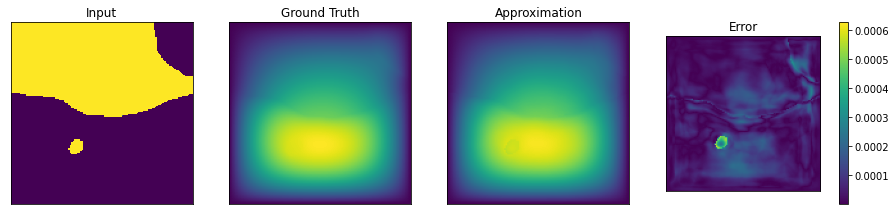

In [ ]:
plot_sample(fig_path, model, test_loader, y_normalizer, train_res)